In [0]:
# Installing Tensorflow 2.0
# !python3 -m pip install tensorflow==2.0.0-beta1
import warnings
warnings.filterwarnings('ignore')

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

# Install TensorFlow
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf

# Make sure that we have the correct version
# Expected result: '2.0.0-beta1'
tf.__version__

TensorFlow 2.x selected.


'2.0.0-rc0'

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import random
import shutil
import os
import pathlib
import pandas as pd
from PIL import Image
from tensorflow.compat.v2.keras.preprocessing.image import ImageDataGenerator, load_img

## Define Constants

In [0]:
IMAGE_WIDTH = 160
IMAGE_HEIGHT = 160
IMAGE_SIZE = (IMAGE_WIDTH, IMAGE_HEIGHT)
BATCH_SIZE = 32

## Load and preprocess data

In [5]:
from google.colab import drive
drive.mount('gdrive')

Drive already mounted at gdrive; to attempt to forcibly remount, call drive.mount("gdrive", force_remount=True).


### Utils functions

In [0]:
# This function will get all image paths and file size
def get_file_size_from_path(path):
  labels = [x.name for x in path.glob('*') if x.is_dir() and x.name.endswith('0')]
  label_names = {key:value for value, key in enumerate(sorted(labels))}
  
  all_images = [str(x) for x in path.glob('*/*') if x.parent.name in label_names]

  results = []
  for image in all_images:
    fsize = os.path.getsize(image)
    results.append([image, fsize])
  
  return results

# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
  fig, axes = plt.subplots(4, 3, figsize=(12,12))
  axes = axes.flatten()
  for img, ax in zip( images_arr, axes):
      ax.imshow(img)
      ax.axis('off')
  plt.tight_layout()
  plt.show()
    
def create_images_df_from_source(data_source_path):
  """
  This function will return a dataframe with image path and file size
  in given data source path
  """
  all_images = [str(x) for x in data_source_path.glob('*/*') if x.parent.name in label_names and x.is_file()]

  all_images_with_size = []
  count = 0
  for image in all_images:

    fsize = os.path.getsize(image)
#     im = Image.open(image)
    all_images_with_size.append([image, fsize])
    count += 1

    if count % 100 == 0:
      print('Computing {} images'.format(count))

  print('total images:', len(all_images_with_size))
  
  df = pd.DataFrame(all_images_with_size, columns=['filename', 'filesize'])
  
  return df

### Initiate required paths

In [7]:
# path to the data folder
data_root = pathlib.Path('/content/gdrive/My Drive/PROJECTS/CoderSchool_Fansipan/github_repo/rock_scissors_paper_game/data/')

# path to the raw data source folder
data_source = pathlib.Path('/content/gdrive/My Drive/Team2data/')

# path to the preprocessed data folder
data_cleaned_source = pathlib.Path('/content/gdrive/My Drive/PROJECTS/CoderSchool_Fansipan/github_repo/rock_scissors_paper_game/data/cleaned_source/')

# path to where we save the trained model
export_path = pathlib.Path('/content/gdrive/My Drive/PROJECTS/CoderSchool_Fansipan/github_repo/rock_scissors_paper_game/static/models/')

print(data_root)
print(data_source)
print(data_cleaned_source)
print(export_path)

/content/gdrive/My Drive/PROJECTS/CoderSchool_Fansipan/github_repo/rock_scissors_paper_game/data
/content/gdrive/My Drive/Team2data
/content/gdrive/My Drive/PROJECTS/CoderSchool_Fansipan/github_repo/rock_scissors_paper_game/data/cleaned_source
/content/gdrive/My Drive/PROJECTS/CoderSchool_Fansipan/github_repo/rock_scissors_paper_game/static/models


### Get all labels and count total images of each labels

In [8]:
from collections import Counter

# Find all labels
labels = [x.name for x in data_source.glob('*') if x.is_dir()]
label_names = sorted(item.name for item in data_source.glob('*/') if item.is_dir())
print('all labels:', label_names)

# Find all image's path
all_image_paths = list(data_source.glob("*/*"))
all_image_paths = [str(path) for path in all_image_paths if path.is_file()]

# Find all image's labels
label_to_index = dict((name, index) for index, name in enumerate(label_names))
all_image_labels = [label_to_index[pathlib.Path(path).parent.name]
                    for path in all_image_paths]

# Count #image each class
count = Counter()

for label in all_image_labels:
  count[label_names[label]] += 1
  
count

all labels: ['paper', 'rock', 'scissors']


Counter({'paper': 3005, 'rock': 2954, 'scissors': 2858})

### EDA and Image Preprocessing

#### Create a DataFrame for all images

In [9]:
df_source_images = create_images_df_from_source(data_source)
df_source_images.info()
df_source_images.sample(5)

Computing 100 images
Computing 200 images
Computing 300 images
Computing 400 images
Computing 500 images
Computing 600 images
Computing 700 images
Computing 800 images
Computing 900 images
Computing 1000 images
Computing 1100 images
Computing 1200 images
Computing 1300 images
Computing 1400 images
Computing 1500 images
Computing 1600 images
Computing 1700 images
Computing 1800 images
Computing 1900 images
Computing 2000 images
Computing 2100 images
Computing 2200 images
Computing 2300 images
Computing 2400 images
Computing 2500 images
Computing 2600 images
Computing 2700 images
Computing 2800 images
Computing 2900 images
Computing 3000 images
Computing 3100 images
Computing 3200 images
Computing 3300 images
Computing 3400 images
Computing 3500 images
Computing 3600 images
Computing 3700 images
Computing 3800 images
Computing 3900 images
Computing 4000 images
Computing 4100 images
Computing 4200 images
Computing 4300 images
Computing 4400 images
Computing 4500 images
Computing 4600 imag

,filename,filesize
870,/content/gdrive/My Drive/Team2data/rock/2019-0...,38958
5896,/content/gdrive/My Drive/Team2data/paper/20180...,184467
3745,/content/gdrive/My Drive/Team2data/paper/2019-...,41311
7900,/content/gdrive/My Drive/Team2data/scissors/20...,41530
4104,/content/gdrive/My Drive/Team2data/paper/IMG_2...,71228


#### Visualize all images by file size

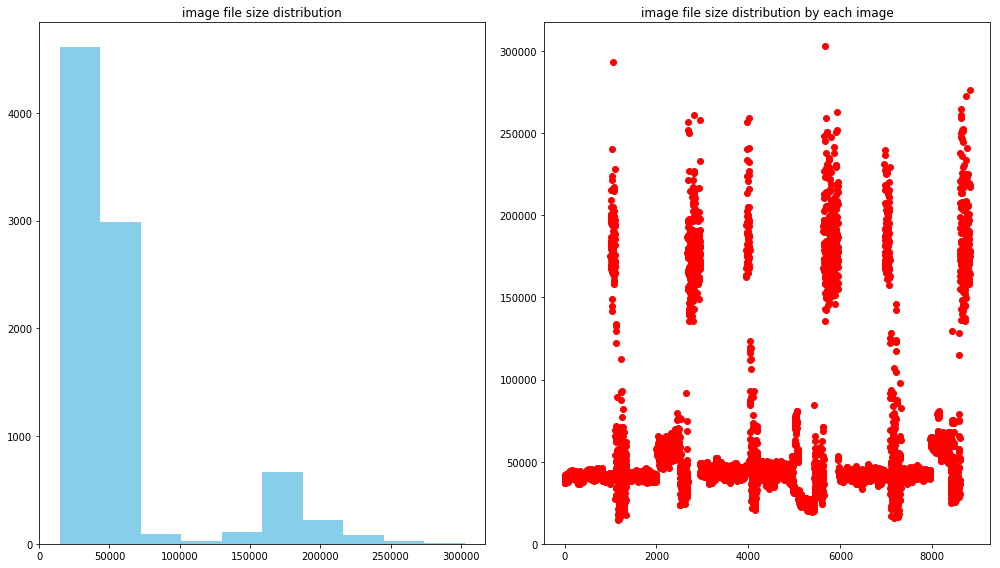

In [10]:
fig, ax = plt.subplots(1, 2, figsize=[14, 8])

ax[0].hist(df_source_images.filesize, color="skyblue")
ax[0].set_title('image file size distribution')

ax[1].plot(df_source_images.filesize, 'ro')
ax[1].set_title('image file size distribution by each image')

plt.tight_layout()
plt.show()

#### Image resizing
The following code will go through all images in the source data folder and do the following tasks:
1. Check if the image is PNG and convert to JPEG.
2. Check if the destination folder is existed or not, then create that folder.
3. If resize is enabled, all source images will be resized to the target size.
4. All images will be copied to the destination folder.

In [0]:
def preprocess_images(path_src, path_dest, resize=False, target_size=500, verbose=0):
  """
  This function will preprocess all images inside source folder and copy to destination folder
  Parameters:
  - path_src: the path of source folder.
  - path_dest: the path of destination folder.
  - resize: True or False. Set to True will resize all the images to the target_size
  - target_size: Integer. If resize is True, set the target_size will resize the image with the shorter dimension having the target_size.
  - verbose: print out the progress. 0 or 1.
  """
  
  all_images_for_resizing = [str(x) for x in path_src.glob('*/*') if x.parent.name in label_names and x.is_file()]

  for image_path in all_images_for_resizing:

    image = Image.open(image_path)

    # check if image is PNG
    if len(image.split()) > 3:
      #convert PNG to JPEG
      image = image.convert('RGB')

    # check destination folders
    if not path_dest.is_dir():
      # destination train folder is not existed, create one
      os.mkdir(path_dest)

    # get the file name
    image_splits = image_path.rsplit('/', 2)
    dest_folder = pathlib.Path(os.path.join(path_dest, image_splits[1]))

    # if destination label folder not existed, then create one
    if not dest_folder.is_dir():
      os.mkdir(dest_folder)

    # set destination file name
    dest_filename = pathlib.Path(os.path.join(image_path.rsplit('/', 2)[-2], image_path.rsplit('/', 2)[-1]))
    # set new destination
    dest_filename = pathlib.Path(os.path.join(path_dest, dest_filename))

    # image resizing process
    if resize and (image.width > target_size or image.height > target_size):
      # set the new dimensions
      if (image.width > image.height): # landscape image
        new_size = (int(target_size*(image.width/image.height)), target_size )

      else: # portrait image
         new_size = (target_size, int(target_size*(image.width/image.height)))

      output = image.resize(new_size)

      # save all resized file to new destination
      if not dest_filename.is_file():
        output.save(dest_filename)

    else: # now working on the rest images
      if not dest_filename.is_file():
        image.save(dest_filename)
    
    if verbose == 1:
      print(dest_filename)
      
      if resize:
        print('current size: ({}, {})'.format(image.width, image.height))
        print('new size:', new_size)
      
# Since our source images have relatively small sizes, so there is no needs to resize the source images
#preprocess_images(path_src=data_source, path_dest=data_cleaned_source, resize=False, verbose=1)

### Train - Validation Splitting

In [12]:
from sklearn.model_selection import train_test_split
from collections import Counter

# set the path to the data source folder
final_data_source = data_cleaned_source

# Find all labels
labels = [x.name for x in final_data_source.glob('*') if x.is_dir()]
label_names = sorted(item.name for item in final_data_source.glob('*/') if item.is_dir())
label_names = np.array(label_names)
print('all labels:', label_names)

# Find all image's path
all_image_paths = list(final_data_source.glob("*/*"))
all_image_paths = [str(path) for path in all_image_paths if path.is_file()]

# Find all image's labels
label_to_index = dict((name, index) for index, name in enumerate(label_names))
all_image_labels = [label_to_index[pathlib.Path(path).parent.name]
                    for path in all_image_paths]

# Count #image each class
count = Counter()

for label in all_image_labels:
  count[label_names[label]] += 1
  
print(count)

train_image_paths, val_image_paths, train_image_labels, val_image_labels = train_test_split(all_image_paths, all_image_labels, test_size=0.1, random_state=101)

total_train_images = len(train_image_paths)
total_val_images = len(val_image_paths)

print('total train images:', total_train_images)
print('total validation images:', total_val_images)

# Find all train & validation image's labels
train_image_labels = [label_to_index[pathlib.Path(path).parent.name]
                    for path in train_image_paths]

val_image_labels = [label_to_index[pathlib.Path(path).parent.name]
                    for path in val_image_paths]

# Count # of train image each class
train_count = Counter()
val_count = Counter()

for label in train_image_labels:
  train_count[label_names[label]] += 1
  
for label in val_image_labels:
  val_count[label_names[label]] += 1
  
print("total train images by each label:\n", train_count)
print("total validation images by each label:\n", val_count)


all labels: ['paper' 'rock' 'scissors']
Counter({'paper': 3005, 'rock': 2954, 'scissors': 2858})
total train images: 7935
total validation images: 882
total train images by each label:
 Counter({'paper': 2718, 'rock': 2643, 'scissors': 2574})
total validation images by each label:
 Counter({'rock': 311, 'paper': 287, 'scissors': 284})


### BONUS: Train - Validation Splitting
There are two way to train augmented images in Tensorflow: 
* Using flow_from_dataframe
* Using flow_from_directory

In other to use flow_from_directory, we need to create the physical files structure for train and validation images, which mean to copy images from the data source to train and validation folders. The following codes allow us to do so. Please uncomment the code to see how it works.

In [0]:
# # path to train data folder
# data_train_path = pathlib.Path('/content/gdrive/My Drive/PROJECTS/CoderSchool_Fansipan/github_repo/rock_scissors_paper_game/data/train')

# #path to validation data folder
# data_val_path = pathlib.Path('/content/gdrive/My Drive/PROJECTS/CoderSchool_Fansipan/github_repo/rock_scissors_paper_game/data/validation')

# def train_val_split(path_src, train_dest, val_dest, verbose=0, random_seed=42, train_size=0.8):
#   """
#   This function will split the data source to train and validation folders
#   Input parameters:
#   - path_src: path to data source folder
#   - train_dest: path to data train folder
#   - val_dest: path to data validation folder
#   - verbose: 0 or 1. Print out the progress. 
#   - random_seed: Integer, default: 42. Set random seed. 
#   - train_size: Float, default: 0.8. Set train images size. 
#   """
  
#   random.seed(random_seed)
  
#   # check if train folder is existed or not
#   if not train_dest.is_dir():
#     # destination train folder is not existed, create one
#     os.mkdir(train_dest)

#   # check if validation folder is existed or not
#   if not val_dest.is_dir():
#     # destination train folder is not existed, create one
#     os.mkdir(val_dest)
  
#   count_train = 0
#   count_val = 0
#   for label in labels:
#     label_path = pathlib.Path(os.path.join(path_src, label))

#     label_images = [image for image in label_path.glob('*') if image.is_file()]
    
#     # shuffle the dataset
#     random.shuffle(label_images)
    
#     # Create the train and validation folders
#     label_images_total = len(label_images)
#     dest_train_path = pathlib.Path(os.path.join(train_dest, label))
#     dest_val_path = pathlib.Path(os.path.join(val_dest, label))
    
#     if not dest_train_path.is_dir():
#       # destination folder is not existed, create one
#       os.mkdir(dest_train_path)

#     if not dest_val_path.is_dir():
#       # destination folder is not existed, create one
#       os.mkdir(dest_val_path)
    
#     # set the total number of train images
#     train_total = int(label_images_total*train_size)
    
#     # distribute source images into train and validation folders
#     for index in range(0, train_total):
#       shutil.copy(label_images[index], dest_train_path)
#       if verbose == 1:
#         print("copy:\n", label_images[index])
#         print("to train folder:\n", dest_train_path)
#         print("----------------------------------------------------------------")
#       count_train += 1
    
#     for index in range(train_total, label_images_total):
#       shutil.copy(label_images[index], dest_val_path)
#       if verbose == 1:
#         print("copy:\n", label_images[index])
#         print("to validation folder:\n", dest_val_path)
#         print("----------------------------------------------------------------")
#       count_val += 1

#     print('total train images:', count_train)
#     print('total validation images:', count_val)

# train_val_split(path_src=data_source, train_dest=data_train_path, val_dest=data_val_path, verbose=1, train_size=0.8)

### Plot some preprocessed images

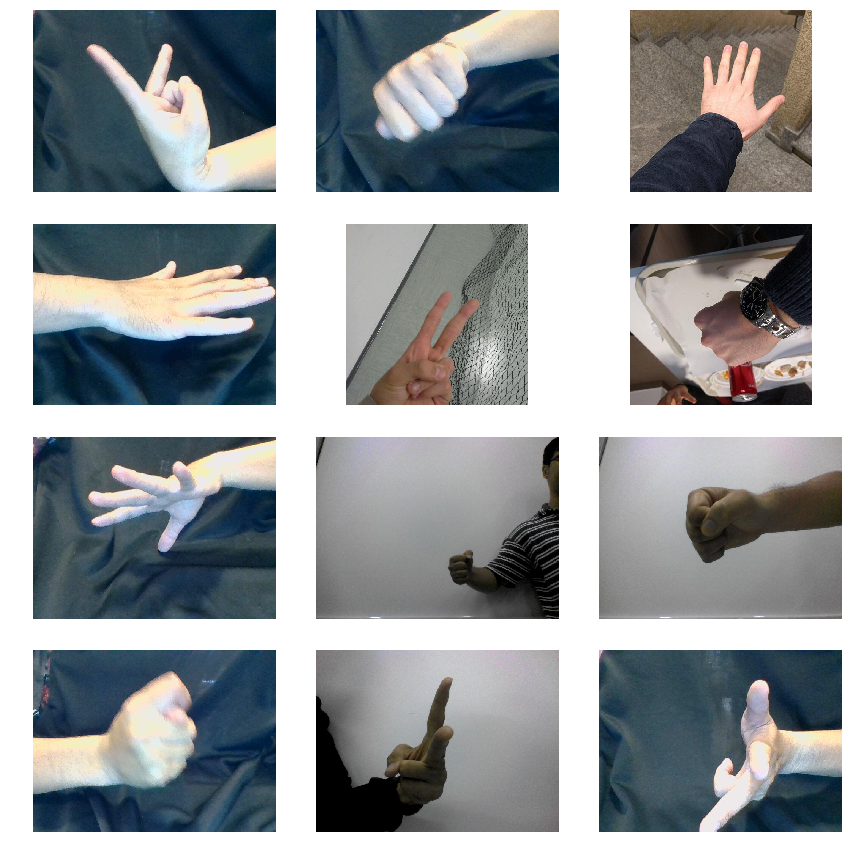

In [14]:
# all_preprocessed_images = [str(x) for x in data_train_path.glob('*/*') if x.parent.name in label_names]

random.shuffle(train_image_paths)

image_list = []
for image_path in train_image_paths[:12]:
  image = Image.open(image_path)
  image_list.append(image)

plotImages(image_list)

## Create model

In [15]:
df_train = pd.DataFrame({'paths':train_image_paths, 'labels':label_names[train_image_labels]})
df_val = pd.DataFrame({'paths':val_image_paths, 'labels':label_names[val_image_labels]})

# Preprocess Train dataset
train_img_datagen = ImageDataGenerator(
                                        rescale=1./255,
                                        rotation_range=40,
#                                         zoom_range=0.15,
#                                         width_shift_range=0.2,
#                                         height_shift_range=0.2,
#                                         shear_range=0.15,
                                        brightness_range = (1, 1.5),
                                        horizontal_flip=True,
                                        vertical_flip=True,
                                        fill_mode="nearest"
                                      )

train_generator = train_img_datagen.flow_from_dataframe(df_train,
                                                 x_col='paths',
                                                 y_col='labels',
                                                 batch_size=BATCH_SIZE,
                                                 shuffle=True,
                                                 class_mode='sparse',
                                                 target_size=(IMAGE_HEIGHT,IMAGE_WIDTH))

# Preprocess Validation dataset
validation_img_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_img_datagen.flow_from_dataframe(df_val,
                                                 x_col='paths',
                                                 y_col='labels',
                                                 batch_size=BATCH_SIZE,
                                                 class_mode='sparse',
                                                 target_size=(IMAGE_HEIGHT,IMAGE_WIDTH))

Found 7935 validated image filenames belonging to 3 classes.
Found 882 validated image filenames belonging to 3 classes.


## Plot augmented images

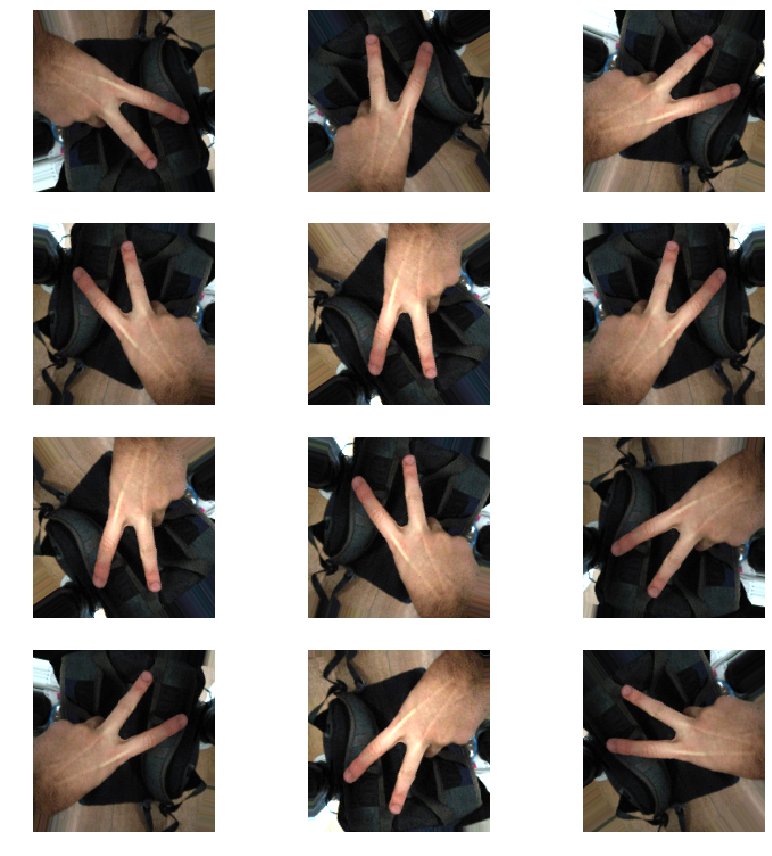

In [16]:
index = np.random.randint(0, len(train_generator))
augmented_images = [train_generator[index][0][0] for i in range(15)]
plotImages(augmented_images)

In [0]:
# from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization, GlobalAveragePooling2D

# def create_model():
  
#   model = tf.keras.Sequential()
  
#   model.add(Conv2D(filters=8, kernel_size=(3, 3), strides=2, activation='relu', padding='same', input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
#   model.add(BatchNormalization())
#   model.add(MaxPooling2D(pool_size=(2, 2)))
#   model.add(Dropout(0.2))
  
#   model.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same'))
#   model.add(BatchNormalization())
#   model.add(MaxPooling2D(pool_size=(2, 2)))
#   model.add(Dropout(0.2))

#   model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
#   model.add(BatchNormalization())
#   model.add(MaxPooling2D(pool_size=(2, 2)))
#   model.add(Dropout(0.2))

#   model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
#   model.add(BatchNormalization())
#   model.add(MaxPooling2D(pool_size=(2, 2)))
#   model.add(Dropout(0.2))

#   model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'))
#   model.add(BatchNormalization())
#   model.add(MaxPooling2D(pool_size=(2, 2)))
#   model.add(Dropout(0.2))

#   model.add(Flatten())
#   model.add(Dense(1024, activation='relu'))
#   model.add(BatchNormalization())
#   model.add(Dropout(0.2))
# #   model.add(GlobalAveragePooling2D()),
#   model.add(Dense(len(label_names), activation='softmax')) 
#   model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# #   model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-6), loss='binary_crossentropy', metrics=['accuracy'])

#   return model

# model = create_model()
# model.summary()

In [18]:
# create a model with transfer learning from MobileNet model
mobile_net = tf.keras.applications.MobileNetV2(input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3), include_top=False)
mobile_net.trainable=False
base_learning_rate = 0.0001

def create_model_tl():
  model = tf.keras.Sequential([
      mobile_net,
      tf.keras.layers.GlobalAveragePooling2D(),
      tf.keras.layers.Dense(len(label_names), activation = 'softmax')])
  
  #tf.keras.optimizers.Adam()
  model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
                loss='sparse_categorical_crossentropy',
                metrics=["accuracy"])
  return model

model_tl = create_model_tl()
model_tl.summary()

9412608/9406464 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Model) (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 3)                 3843      
Total params: 2,261,827
Trainable params: 3,843
Non-trainable params: 2,257,984
_________________________________________________________________


## Train Model

In [0]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

class CollectBatchStats(tf.keras.callbacks.Callback):
    def __init__(self):
        self.batch_losses = []
        self.batch_acc = []
        self.batch_val_losses = []
        self.batch_val_acc = []

    def on_train_batch_end(self, batch, logs=None):
        self.batch_losses.append(logs['loss'])
        self.batch_acc.append(logs['accuracy'])
#         self.model.reset_metrics()
  
    def on_test_batch_end(self, batch, logs=None):
        self.batch_val_losses.append(logs['loss'])
        self.batch_val_acc.append(logs['accuracy'])
#         self.model.reset_metrics()

batch_stats_callback = CollectBatchStats()
callbacks = [
#     EarlyStopping(patience=10, verbose=1),
    batch_stats_callback,
    ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.0001, verbose=1), # learning rate decay
    ModelCheckpoint(os.path.join(export_path, 'checkpoint-model_tl_ep80_192x192.h5'), verbose=1, save_best_only=True)
]

In [0]:
initial_epochs = 40

history_tl = model_tl.fit_generator(
    train_generator,
    steps_per_epoch=total_train_images // BATCH_SIZE,
    epochs=initial_epochs,
    validation_data=validation_generator,
    validation_steps=total_val_images // BATCH_SIZE,
    workers=5,
    use_multiprocessing=True,
    callbacks=callbacks
)

Epoch 1/40
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
246/247 [============================>.] - ETA: 0s - loss: 1.2563 - accuracy: 0.3311
Epoch 00001: val_loss improved from inf to 1.53975, saving model to /content/gdrive/My Drive/PROJECTS/CoderSchool_Fansipan/github_repo/rock_scissors_paper_game/static/models/checkpoint-model_tl_ep80_192x192.h5
247/247 [==============================] - 128s 519ms/step - loss: 1.2563 - accuracy: 0.3309 - val_loss: 1.5398 - val_accuracy: 0.2315
Epoch 2/40
246/247 [============================>.] - ETA: 0s - loss: 1.2210 - accuracy: 0.3390
Epoch 00002: val_loss improved from 1.53975 to 1.49295, saving model to /content/gdrive/My Drive/PROJECTS/CoderSchool_Fansipan/github_repo/rock_scissors_paper_game/static/models/checkpoint-model_tl_ep80_192x192.h5
247/247 [==============================] - 127s 512ms/step - loss: 1.2209 - accuracy: 0.3391 - val_loss: 1.4930 - val_accuracy: 0.2350
Epoch 3/40
246/247 [

### Visualize training results

In [0]:
def plot_training_results(training_acc, training_losses, val_acc, val_losses, epoch_acc, epoch_val_acc, epoch_loss, epoch_val_loss):
  plt.figure()
  fig, ax = plt.subplots(2, 2, figsize=[14, 14])
  
  # Plot batch's training & validation losses
  ax[0, 0].set_ylabel("Loss")
  ax[0, 0].set_xlabel("Training Steps")

  training_steps = len(training_losses)
  test_steps = len(val_losses)
  ax[0, 0].plot(training_losses, label='Batch Training Loss')
  ax[0, 0].plot(np.linspace(0, training_steps, test_steps), val_losses, label='Batch Validation Loss')
  ax[0, 0].set_ylim([0,max(ax[0, 0].set_ylim())])
  ax[0, 0].legend(loc='upper right')

  # Plot batchs training & validation accuracy
  ax[0, 1].set_ylabel("Accuracy")
  ax[0, 1].set_xlabel("Training Steps")

  training_steps = len(training_acc)
  test_steps = len(val_acc)
  ax[0, 1].plot(training_acc, label='Batch Training Accuracy')
  ax[0, 1].plot(np.linspace(0, training_steps, test_steps), val_acc, label='Batch Validation Accuracy')
  ax[0, 1].set_ylim([0,1])
  ax[0, 1].legend(loc='lower right')

  # Plot epochs training & validation losses
  ax[1, 0].set_ylabel("Loss")
  ax[1, 0].set_xlabel("Epochs")

  train_epochs = len(epoch_loss)
  val_epochs = len(epoch_val_loss)
  ax[1, 0].plot(epoch_loss, label='Epoch Training Loss')
  ax[1, 0].plot(np.linspace(0, train_epochs, val_epochs), epoch_val_loss, label='Epoch Validation Loss')
  ax[1, 0].set_ylim([0,max(ax[1, 0].set_ylim())])
  ax[1, 0].legend(loc='upper right')
  
  # Plot epochs training & validation accuracy
  ax[1, 1].set_ylabel("Accuracy")
  ax[1, 1].set_xlabel("Epochs")

  train_epochs = len(epoch_acc)
  val_epochs = len(epoch_val_acc)
  ax[1, 1].plot(epoch_acc, label='Epoch Training Accuracy')
  ax[1, 1].plot(np.linspace(0, train_epochs, val_epochs), epoch_val_acc, label='Epoch Validation Accuracy')
  ax[1, 1].set_ylim([0,1])
  ax[1, 1].legend(loc='lower right')
    
  plt.show()

plot_training_results(batch_stats_callback.batch_acc,
                      batch_stats_callback.batch_losses, 
                      batch_stats_callback.batch_val_acc, 
                      batch_stats_callback.batch_val_losses,
                      history_tl.history['accuracy'],
                      history_tl.history['val_accuracy'],
                      history_tl.history['loss'],
                      history_tl.history['val_loss']
                     )

### Testing and Preview

In [0]:
for image_batch, label_batch in validation_generator:
  print("Image batch shape: ", image_batch.shape)
  print("Label batch shape: ", label_batch.shape)
  break

In [0]:
# Predict
label_names = np.array(label_names)
predicted_batch = model_tl.predict(image_batch)
predicted_id = np.argmax(predicted_batch, axis=1)
predicted_label_batch = label_names[predicted_id]

In [0]:
# Plot the result
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow((image_batch[n]+1)/2)
  color = "green" if predicted_id[n] == label_batch[n] else "red"
  plt.title(predicted_label_batch[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (green: correct, red: incorrect)")

### Fine Tune the model

In [0]:
mobile_net.trainable=True

In [0]:
print("Number of layers in the base model:", len(mobile_net.layers))

fine_tune_at = 140

for layer in mobile_net.layers[:fine_tune_at]:
    layer.trainable = False

In [0]:
model_tl.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              loss='sparse_categorical_crossentropy',
              metrics=["accuracy"])

model_tl.summary()

In [0]:
fine_tune_epochs = 40
total_epochs = initial_epochs + fine_tune_epochs

history_tl = model_tl.fit_generator(
    train_generator,
    steps_per_epoch=total_train_images // BATCH_SIZE,
    epochs=total_epochs,
    validation_data=validation_generator,
    validation_steps=total_val_images // BATCH_SIZE,
    initial_epoch=initial_epochs,
    workers=5,
    use_multiprocessing=True,
    callbacks=callbacks
)

In [0]:
print(history_tl)

In [0]:
plot_training_results(batch_stats_callback.batch_acc,
                      batch_stats_callback.batch_losses, 
                      batch_stats_callback.batch_val_acc, 
                      batch_stats_callback.batch_val_losses,
                      history_tl.history['accuracy'],
                      history_tl.history['val_accuracy'],
                      history_tl.history['loss'],
                      history_tl.history['val_loss']
                     )

## Export model

In [0]:
#Save the entire model to a HDF5 file
model_tl.save(os.path.join(export_path, 'my_model_tl_ep80_192x192.h5'))

In [0]:
# Test model

reloaded_model = tf.keras.models.load_model(os.path.join(export_path, 'my_model_tl_ep80_192x192.h5'))
reloaded_model.summary()

In [0]:
result_batch = model_tl.predict(image_batch)
reloaded_result_batch = reloaded_model.predict(image_batch)

In [0]:
# Test the predicted result. If the code return 0, then the predicted values of the reloaded model match with the original model's one
abs(reloaded_result_batch - result_batch).max()

In [0]:
labels = train_generator.class_indices
labels